(array([[[ 136., 3285.],
        [ 723., 3271.],
        [ 717., 3850.],
        [ 127., 3873.]]], dtype=float32), array([[[2380., 3228.],
        [2900., 3213.],
        [2910., 3758.],
        [2385., 3783.]]], dtype=float32), array([[[2342.,  332.],
        [2843.,  355.],
        [2853.,  856.],
        [2349.,  838.]]], dtype=float32))


Text(0.5, 1.0, 'aligned and oriented image')

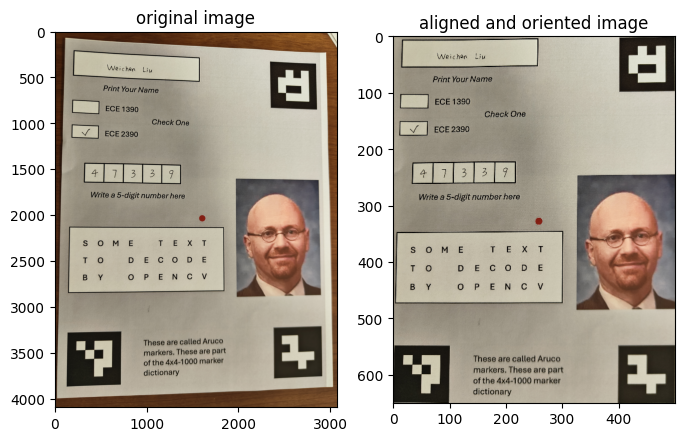

In [1]:
# Using the ACUCO symbols, align and orient the photograph

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('img.jpg')
# img = cv2.imread('Homework8.jpg')

# Load ArUco dictionary and parameters
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
parameters = cv2.aruco.DetectorParameters()

# Detect markers
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
corners, ids, rejected = detector.detectMarkers(gray)
print(corners)

corner1 = corners[0][0][3]
corner2 = corners[1][0][2]
corner3 = corners[2][0][1]

# Calculate the fourth corner
fourth_x = corner1[0] + corner3[0] - corner2[0]
fourth_y = corner1[1] + corner3[1] - corner2[1]
# I make some modification because the paper is not rectangle in the image
corner4 = (fourth_x + 50, fourth_y-300)

source_points = np.array([corner1, corner2, corner3, corner4], dtype="float32")

width, height = 500, 650
destination_points = np.array(
    [
        [0, 0],
        [width-1, 0],  
        [width-1, height-1], 
        [0, height-1],  
    ],
    dtype="float32"
)
matrix = cv2.getPerspectiveTransform(source_points, destination_points)
warped_img = cv2.warpPerspective(img, matrix, (width, height))
aligned_img = cv2.rotate(warped_img, cv2.ROTATE_180)
aligned_img = cv2.flip(aligned_img, 1)


plt.figure(figsize=(8, 5))
plt.subplot(121);plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));  plt.title("original image")
plt.subplot(122);plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB));plt.title("aligned and oriented image")



Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


0    Weichen
1        Liu
Name: 1, dtype: object


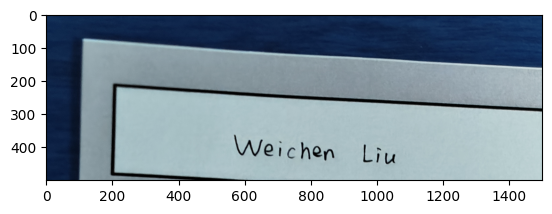

In [3]:
# Using EasyOCR, read in the name box that you wrote
import easyocr
import pandas as pd

name_area = img[ 0:500,0:1500]
# name_area = aligned_img[0:60, 0:280]
plt.imshow(name_area)
name_area = cv2.cvtColor(name_area, cv2.COLOR_BGR2GRAY)
reader = easyocr.Reader(['en'])
result = reader.readtext(name_area)
df=pd.DataFrame(result)
print(df[1])

ECE 2390 is checked


Text(0.5, 1.0, 'aligned and oriented image')

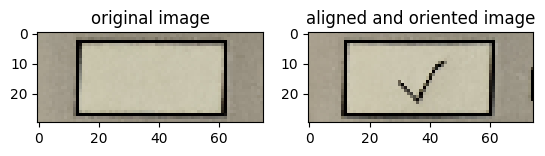

In [4]:
box1 = aligned_img[100:130, 0:75]
box2 = aligned_img[148:178, 0:75]

a = np.mean(box1)
b = np.mean(box2)

if a < b:
    print('ECE 1390 is checked')
else:
    print('ECE 2390 is checked')

plt.subplot(121);plt.imshow(cv2.cvtColor(box1, cv2.COLOR_BGR2RGB));  plt.title("original image")
plt.subplot(122);plt.imshow(cv2.cvtColor(box2, cv2.COLOR_BGR2RGB));plt.title("aligned and oriented image")

In [2]:
from __future__ import print_function

import numpy as np
import cv2 as cv
import itertools as it
# built-in modules
from multiprocessing.pool import ThreadPool

from numpy.linalg import norm

import os

SZ = 20 # size of each digit is SZ x SZ
CLASS_N = 10
DIGITS_FN = "./digits.png"

def clock():
    return cv.getTickCount() / cv.getTickFrequency()

def grouper(n, iterable, fillvalue=None):
    '''grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx'''
    args = [iter(iterable)] * n
    output = it.zip_longest(fillvalue=fillvalue, *args)
    return output

def mosaic(w, imgs):
    '''Make a grid from images.

    w    -- number of grid columns
    imgs -- images (must have same size and format)
    '''
    imgs = iter(imgs)
    img0 = next(imgs)
    pad = np.zeros_like(img0)
    imgs = it.chain([img0], imgs)
    rows = grouper(w, imgs, pad)
    return np.vstack(list(map(np.hstack, rows)))

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    #fn = cv.samples.findFile(fn)
    print('loading "%s" ...' % fn)
    digits_img = cv.imread(fn, cv.IMREAD_GRAYSCALE)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img, M, (SZ, SZ), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return img


class KNearest(object):
    def __init__(self, k = 3):
        self.k = k
        self.model = cv.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        _retval, results, _neigh_resp, _dists = self.model.findNearest(samples, self.k)
        return results.ravel()

    def load(self, fn):
        self.model = cv.ml.KNearest_load(fn)

    def save(self, fn):
        self.model.save(fn)

class SVM(object):
    def __init__(self, C = 1, gamma = 0.5):
        self.model = cv.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv.ml.SVM_RBF)
        self.model.setType(cv.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()

    def load(self, fn):
        self.model = cv.ml.SVM_load(fn)

    def save(self, fn):
        self.model.save(fn)

def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('error: %.2f %%' % (err*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[i, int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    print()

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        vis.append(img)
    return mosaic(25, vis)

def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv.Sobel(img, cv.CV_32F, 1, 0)
        gy = cv.Sobel(img, cv.CV_32F, 0, 1)
        mag, ang = cv.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)

loading "./digits.png" ...
preprocessing...
(4500, 64)
(500, 64)
training KNearest...
error: 3.40 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  1  0  0  0  0  1  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 38  0  2  0  0  0]
 [ 0  0  0  2  0 48  0  0  1  0]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  1  0  0 46  0]
 [ 1  1  0  1  1  0  0  0  2 42]]

training SVM...
error: 1.80 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  2  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 50  0  0  0  0]
 [ 0  0  0  0  1  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 47  0]
 [ 0  1  0  1  0  0  0  0  1 45]]

saving SVM as "digits_svm.dat"...


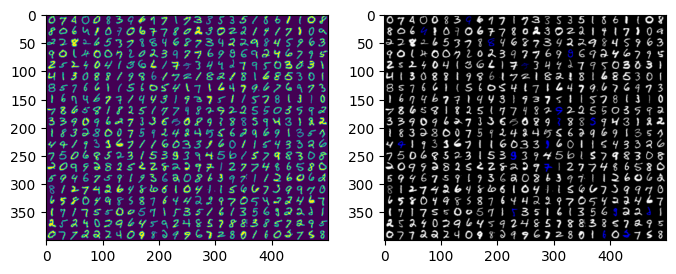

In [3]:
digits, labels = load_digits(DIGITS_FN)

print('preprocessing...')
# shuffle digits
rand = np.random.RandomState(321)
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

digits2 = list(map(deskew, digits))
samples = preprocess_hog(digits2)

train_n = int(0.9*len(samples))
plt.figure(figsize=(8, 5))
plt.subplot(121);plt.imshow(mosaic(25, digits[train_n:]))
# cv.imshow('test set', mosaic(25, digits[train_n:]))
digits_train, digits_test = np.split(digits2, [train_n])
samples_train, samples_test = np.split(samples, [train_n])
labels_train, labels_test = np.split(labels, [train_n])
print(samples_train.shape)
print(samples_test.shape)
print('training KNearest...')
model = KNearest(k=4)
model.train(samples_train, labels_train)
vis = evaluate_model(model, digits_test, samples_test, labels_test)

plt.subplot(122);plt.imshow(vis)
# cv.imshow('KNearest test', vis)

print('training SVM...')
model = SVM(C=2.67, gamma=5.383)
model.train(samples_train, labels_train)
vis = evaluate_model(model, digits_test, samples_test, labels_test)
print('saving SVM as "digits_svm.dat"...')
model.save('digits_svm.dat')

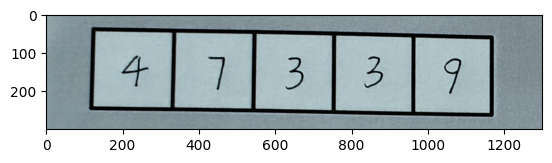

In [6]:
# I don't know how to use the model, use easyocr instead
digit_img = img[1400:1700, 200:1500]

digit_img1 = img[1300:1600, 200:500]
digit_img2 = img[1300:1600, 500:750]
digit_img3 = img[1300:1600, 750:900]
digit_img4 = img[1300:1600, 900:1100]
digit_img5 = img[1300:1600, 1100:1300]

plt.imshow(digit_img)

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def recognize_digits_from_subimage(digit_img1, model_path):
    gray = cv.cvtColor(digit_img1, cv.COLOR_BGR2GRAY) if len(digit_img1.shape) == 3 else digit_img1

    _, thresh = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)
    
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    digits = []

    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if w > 10 and h > 10:  
            roi = thresh[y:y+h, x:x+w]
            roi = cv.resize(roi, (SZ, SZ))  
            roi = deskew(roi)  
            digits.append((x, roi))

    digits.sort(key=lambda d: d[0])
    processed_digits = [digit[1] for digit in digits]

    samples = preprocess_hog(processed_digits)

    svm = cv.ml.SVM_load(model_path)

    results = svm.predict(samples)[1].ravel()

    return results.astype(int)


model_path = "digits_svm.dat"  

recognized_digits = recognize_digits_from_subimage(digit_img1, model_path)
print("Recognized Digits from digit_img1:", recognized_digits[-1])

recognized_digits = recognize_digits_from_subimage(digit_img2, model_path)
print("Recognized Digits from digit_img2:", recognized_digits[-1])

recognized_digits = recognize_digits_from_subimage(digit_img3, model_path)
print("Recognized Digits from digit_img3:", recognized_digits[-1])

recognized_digits = recognize_digits_from_subimage(digit_img4, model_path)
print("Recognized Digits from digit_img4:", recognized_digits[-1])

recognized_digits = recognize_digits_from_subimage(digit_img5, model_path)
print("Recognized Digits from digit_img5:", recognized_digits[-1])

Recognized Digits from digit_img1: 9
Recognized Digits from digit_img2: 7
Recognized Digits from digit_img3: 3
Recognized Digits from digit_img4: 3
Recognized Digits from digit_img5: 7


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

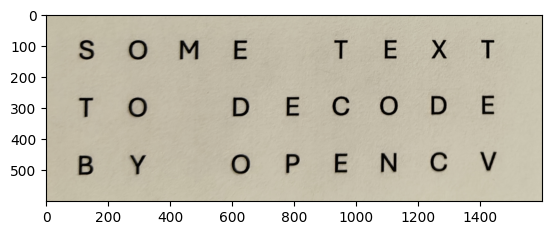

In [ ]:
# There's some problem with pytesseract, so I use bash.
import pytesseract

word_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
word_img = word_img[2200:2800, 200:1800]
plt.imsave('wordimg.jpg',word_img)
plt.imshow(word_img)
print(pytesseract.image_to_string(word_img))


In [ ]:
# I don't know why tesseract decodes the text into that...
! cd C:\Program Files\Tesseract-OCR
! tesseract wordimg.jpg out
output = ''
with open('C:\Program Files\Tesseract-OCR\out.txt') as f:
    for line in f:
        output += line
print(output)

> SM sz i Dee eee age

, =

yD. £64. 0 2. :t
Oo FP £N C V



'tesseract' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


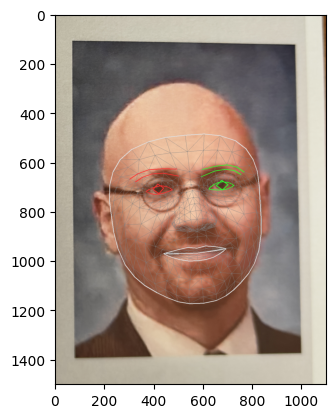

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


image_path = "img.jpg"  
image = cv2.imread(image_path)
image = image[1500:3000, 1900:3000]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(image_rgb)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())

# Save and display the result

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

